<a href="https://colab.research.google.com/github/LuciaTembe/Toxicity_Classification_Project/blob/main/Toxicity_Classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity Comments Classification


## Importing Libraries:

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
import warnings
from keras import backend as K
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Data:

In [ ]:
train_df=pd.read_csv('train.csv', index_col='id', engine='python', error_bad_lines=False)
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006.0,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006.0,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


In [ ]:
test_df=pd.read_csv('test.csv', index_col='id', engine='python', error_bad_lines=False)
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,19659.000000,19659.000000,19659.000000,19659.000000,19659.000000,19659.000000,4071.000000,4071.000000,4071.000000,4071.000000,...,10299.000000,19658.000000,19658.000000,19658.000000,19658.0,19658.000000,19658.000000,19658.000000,19658.000000,19658.000000
mean,0.084281,0.003889,0.014352,0.017229,0.064912,0.008836,0.006798,0.005908,0.003530,0.037715,...,253872.249150,57409.438346,0.000509,0.000051,0.0,1.561196,0.000051,0.006276,1.729271,8.429291
std,0.179192,0.021651,0.071787,0.068319,0.156399,0.047342,0.067401,0.071002,0.040532,0.172804,...,7223.631596,22673.695307,0.022549,0.007132,0.0,2.866472,0.007132,0.044570,32.288787,49.393687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,229671.000000,2006.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,248028.000000,42293.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,254419.000000,51188.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,4.000000
75%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,259948.000000,55312.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,6.000000
max,1.000000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,266227.000000,106343.000000,1.000000,1.000000,0.0,60.000000,1.000000,0.948495,1842.000000,1867.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 59848 to 266266
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   target                               19659 non-null  float64
 1   comment_text                         19659 non-null  object 
 2   severe_toxicity                      19659 non-null  float64
 3   obscene                              19659 non-null  float64
 4   identity_attack                      19659 non-null  float64
 5   insult                               19659 non-null  float64
 6   threat                               19659 non-null  float64
 7   asian                                4071 non-null   float64
 8   atheist                              4071 non-null   float64
 9   bisexual                             4071 non-null   float64
 10  black                                4071 non-null   float64
 11  buddhist               

In [ ]:
train_df.isnull().sum()

target                                     0
comment_text                               0
severe_toxicity                            0
obscene                                    0
identity_attack                            0
insult                                     0
threat                                     0
asian                                  15588
atheist                                15588
bisexual                               15588
black                                  15588
buddhist                               15588
christian                              15588
female                                 15588
heterosexual                           15588
hindu                                  15588
homosexual_gay_or_lesbian              15588
intellectual_or_learning_disability    15588
jewish                                 15588
latino                                 15588
male                                   15588
muslim                                 15588
other_disa

In [ ]:
test_df.isnull().sum()

comment_text    0
dtype: int64

**No Null values for target and comment_text columns**

In [ ]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (19659, 44) (37316, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

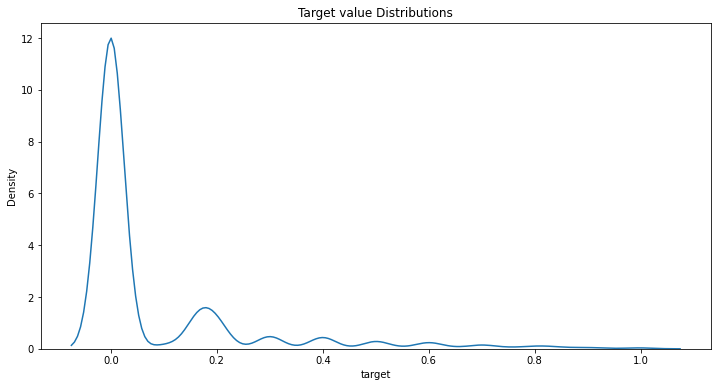

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

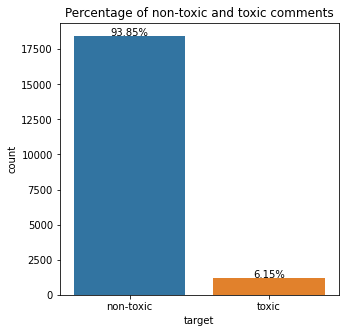

In [ ]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [ ]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

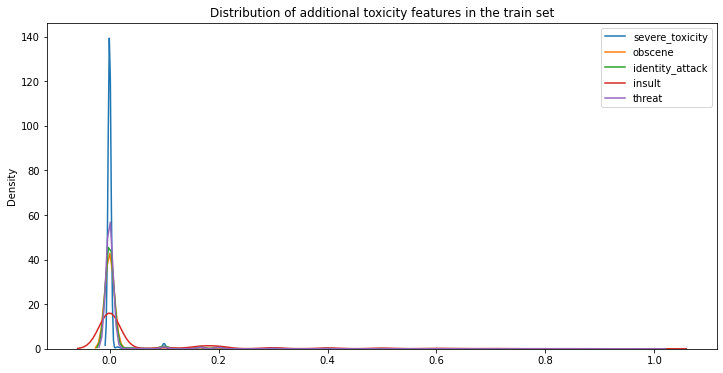

In [ ]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

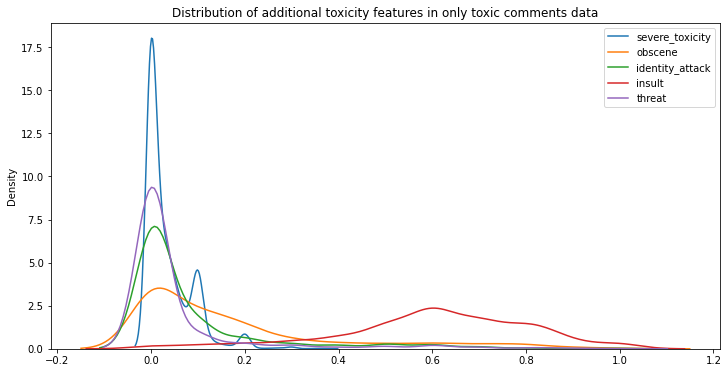

In [ ]:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

In [ ]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

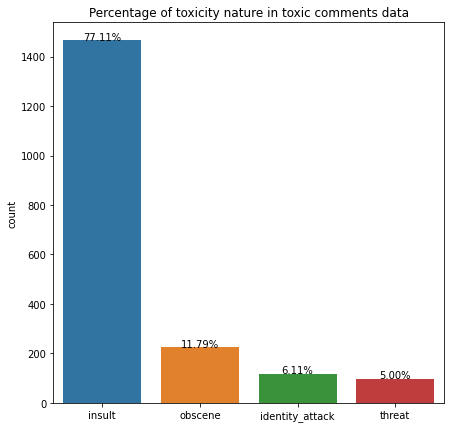

In [ ]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [ ]:
temp = train_df.dropna(axis = 0, how = 'any')

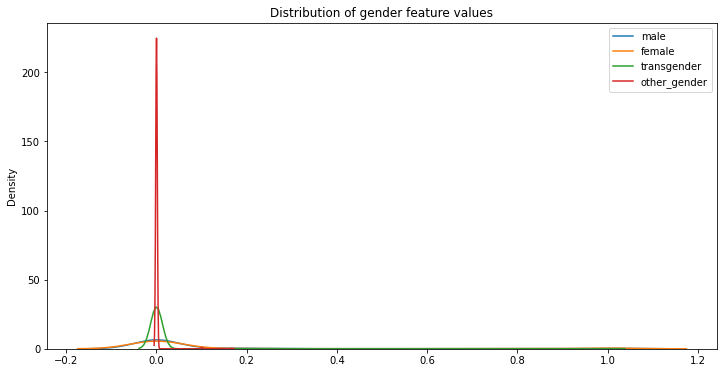

In [ ]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

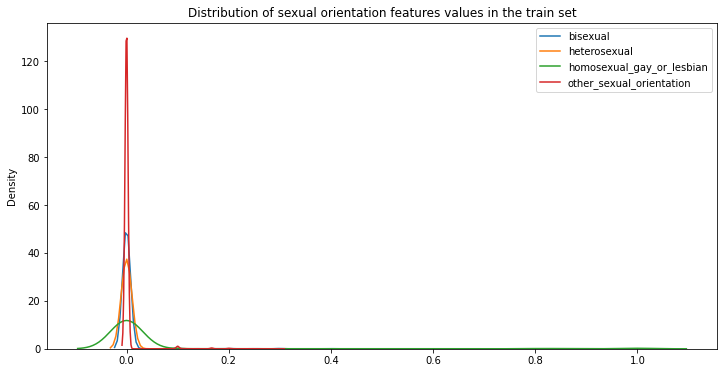

In [ ]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

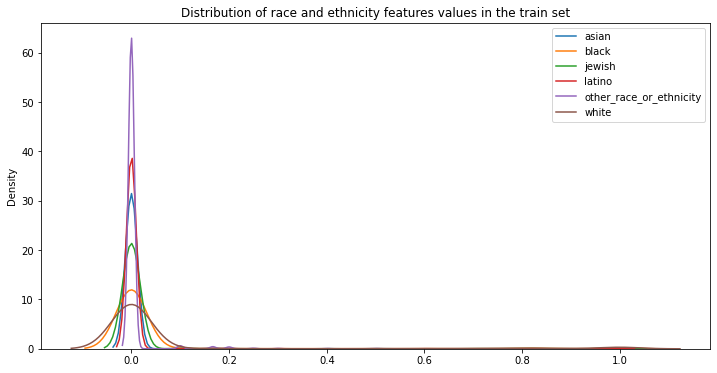

In [ ]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

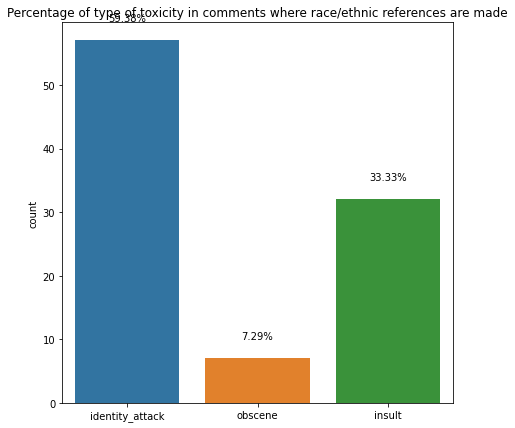

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

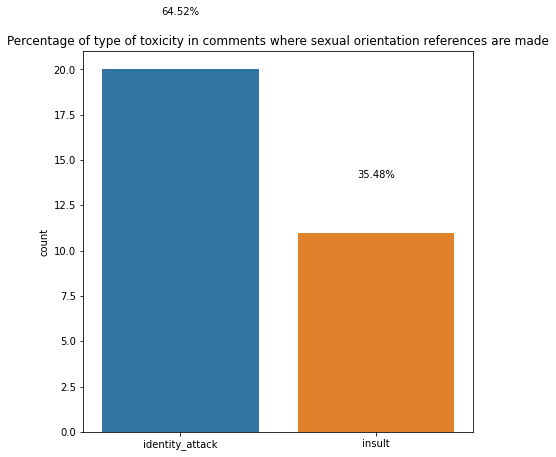

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

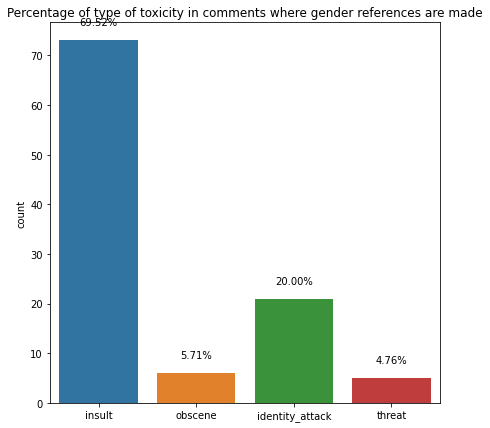

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [ ]:
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

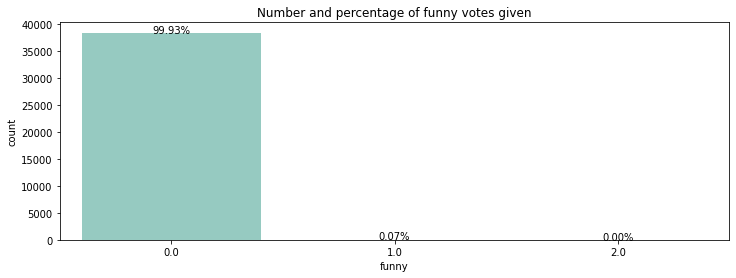

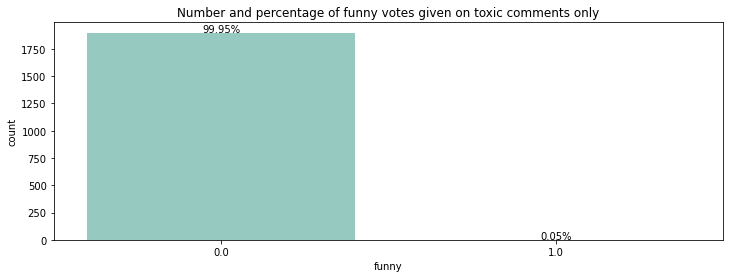

In [ ]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

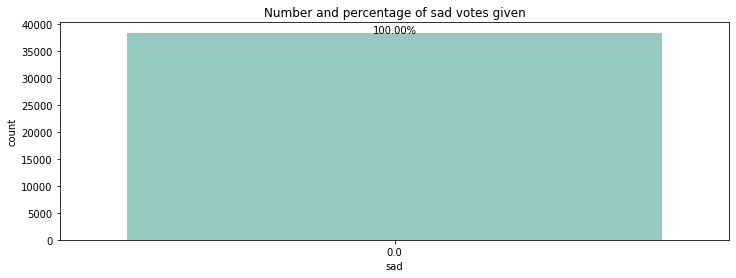

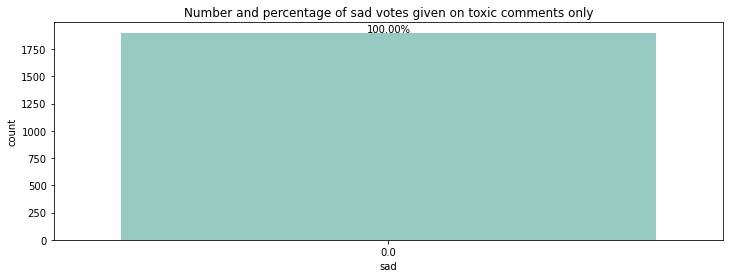

In [ ]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

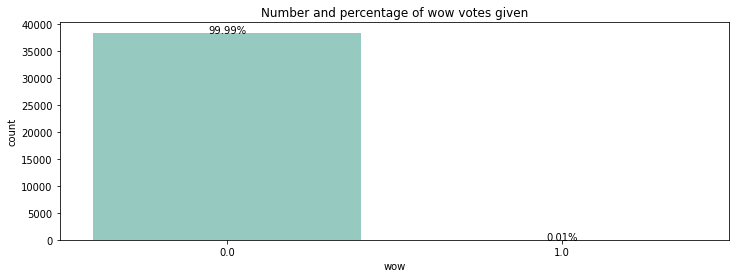

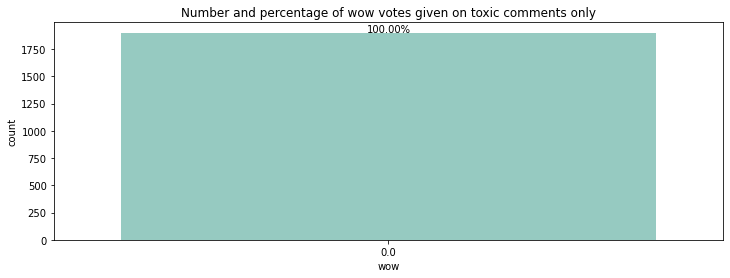

In [ ]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

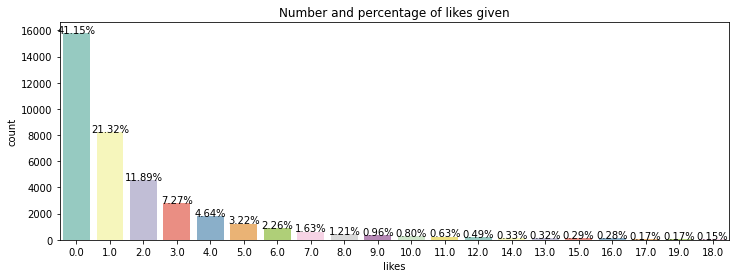

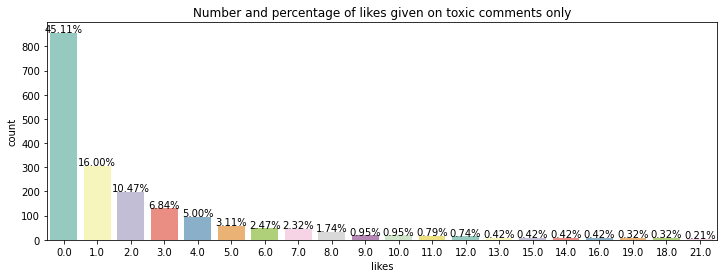

In [ ]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

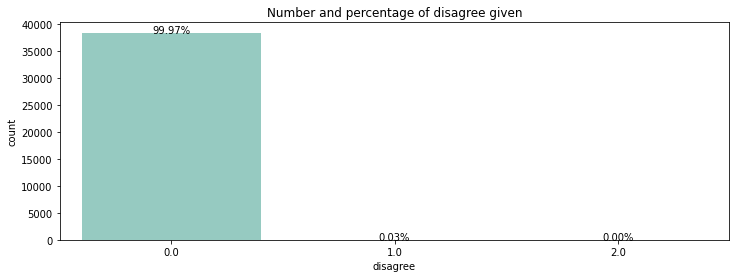

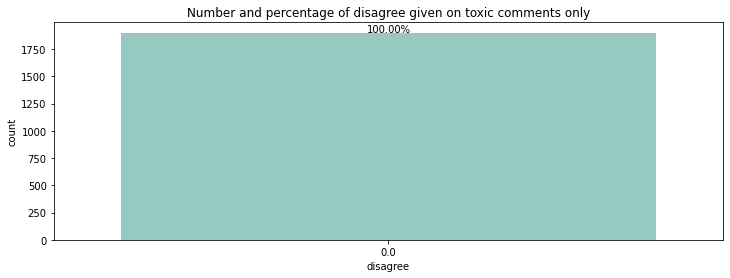

In [ ]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [ ]:
stopwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
#WordCloud
# show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

In [ ]:
# show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(200), 
              #  title = 'Prevalent comments with insult score > 0.75')7

In [ ]:
# show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
#                title = 'Prevalent words in comments with threat score > 0.75')

In [ ]:
# show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
#                title = 'Prevalent words in comments with obscene score > 0.75')

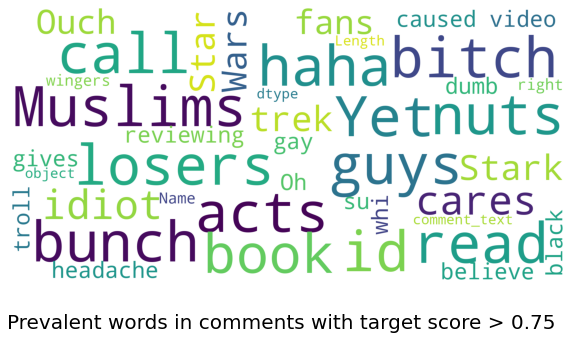

In [ ]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

In [ ]:
# show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
#                title = 'Prevalent words in comments with target score < 0.25')

In [ ]:
# show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
#                title = 'Prevalent words in comments with obscene score < 0.25')

In [ ]:
# show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
#                title = 'Prevalent words in comments with threat score < 0.25')

In [ ]:
# show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
#                title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    if text_string is None:
      text_string = ""
    else:
      text_string = text_string.lower() # Convert everything to lower case.
      text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [ ]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 18.2 s, sys: 68.4 ms, total: 18.3 s
Wall time: 22.9 s


In [ ]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0,haha guy bunch loser


In [ ]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 20.3 s, sys: 49 ms, total: 20.3 s
Wall time: 20.3 s


In [ ]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(28831, 1)
(9611, 1)
(28831, 1)
(9611, 1)


In [ ]:
X_train.head()

,preprocessed_text
id,
285050,murkowski never never never republican believ ...
245917,disappoint democrat legisl unusu find agreemen...
260104,sound expens joe put gun sign save us lot money
274003,actual jay elvi one best assembl rep midtown d...
283056,theresa allow correct grossli mistaken account...


In [ ]:
X_cv.head()

,preprocessed_text
id,
242525,wow remind time fli kip look old hard believ a...
282117,poor legisl ordinari citizen feel overwhelm cr...
278424,prove point
280514,resid southeast sinc 1960 juneau resid sinc ea...
285880,good


In [ ]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [ ]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [ ]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [ ]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(28831, 30000)
(9611, 30000)
(57803, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.020909135563836053
Mean Squared Error on cv set:  0.024880228391867633
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.019802228663479707
Mean Squared Error on cv set:  0.024656927496306737
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02310687700376053
Mean Squared Error on cv set:  0.02521508008595131
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.020267649658480408
Mean Squared Error on cv set:  0.024970336003791883
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.0277930402166073
Mean Squared Error on cv set:  0.029260152467257508
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.020532928212643943
Mean Squared Error on cv set:  0.025048011124046695
***************************************

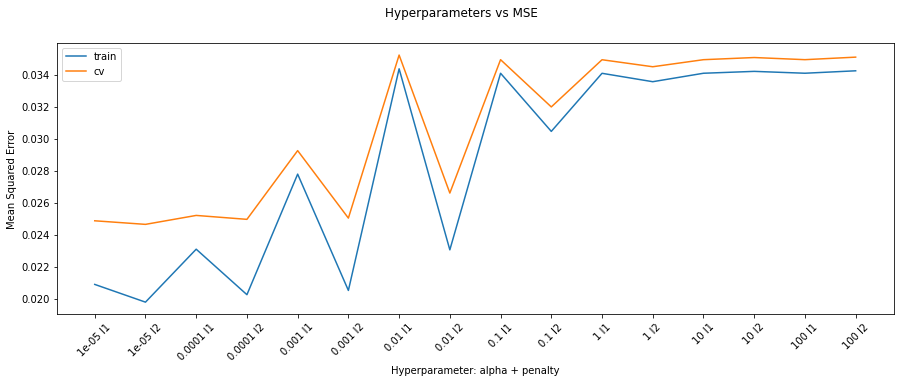

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.340558
idiot,0.292418
crap,0.140981
damn,0.131846
dumb,0.125512
fool,0.116848
ridicul,0.112978
moron,0.112116
ignor,0.100970
hypocrit,0.096925


In [ ]:
# 20 most important words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
came,-0.018344
big lie,-0.018022
import,-0.016196
direct,-0.016175
went,-0.016005
togeth,-0.015958
incid,-0.015738
mass shoot,-0.015423
hold,-0.015400
commit,-0.015178


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.027758184289773034
Mean Squared Error on cv set:  0.029250595472876912
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0279593809941456
Mean Squared Error on cv set:  0.029583755295391617
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03332541062441402
Mean Squared Error on cv set:  0.03420576816910532
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.02670656404792465
Mean Squared Error on cv set:  0.028560662045458457
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.027116624673994533
Mean Squared Error on cv set:  0.028895755197257542
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on t

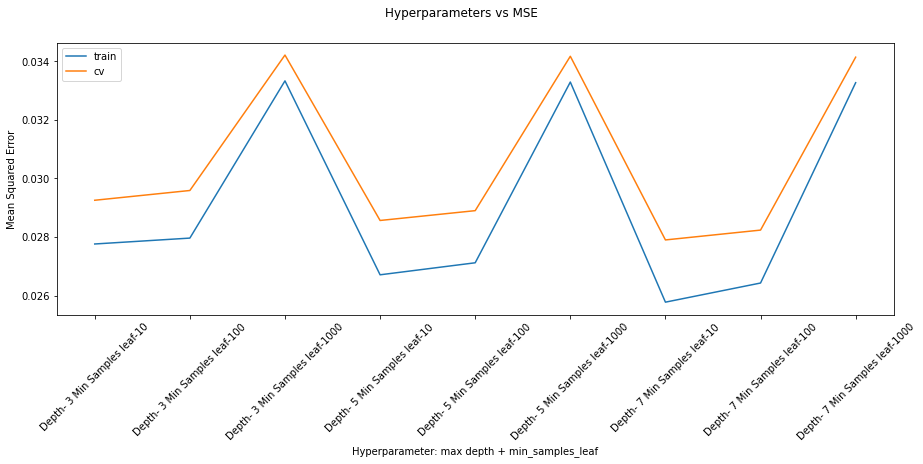

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.412763
idiot,0.241075
crap,0.074251
moron,0.061922
damn,0.058137
dumb,0.052218
racist,0.050933
state,0.006670
would,0.005782
think,0.005183


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(28831, 30000)
(9611, 30000)
(57803, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.031935916865992224
Mean Squared Error on cv set:  0.03288602562433438
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.03174620475098652
Mean Squared Error on cv set:  0.03279444905688919
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.03263758553320055
Mean Squared Error on cv set:  0.033500853812748636
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.03175647050999893
Mean Squared Error on cv set:  0.03280069275222126
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03402242846887766
Mean Squared Error on cv set:  0.03488403289970678
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03187001012650845
Mean Squared Error on cv set:  0.03290439644476635
*********************************************

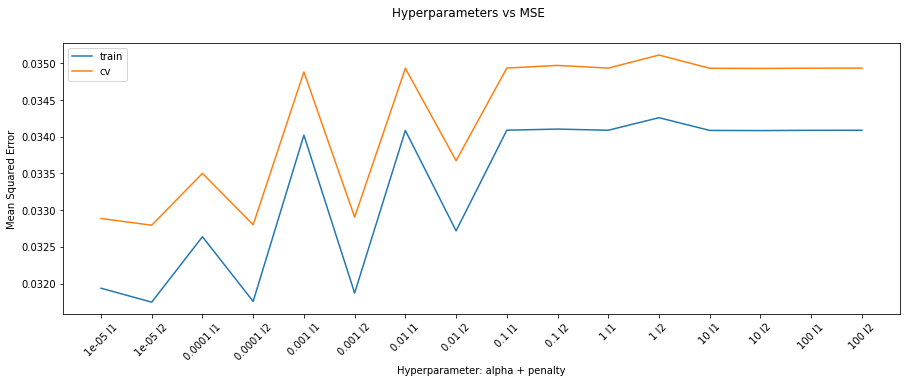

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.148660
idiot,0.111914
peopl,0.082602
like,0.078881
ignor,0.069227
white,0.063814
racist,0.056957
kill,0.056605
get,0.055851
trump,0.052080


In [ ]:
# 20 most important words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.006772
invest,-0.003672
sale,-0.003646
afford,-0.003638
improv,-0.003528
sale tax,-0.003236
provid,-0.003097
fund,-0.003082
incom,-0.002926
incom tax,-0.002746


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.02753919657858527
Mean Squared Error on cv set:  0.02909032272521739
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.02775012710130475
Mean Squared Error on cv set:  0.029449472395269027
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033285293725811675
Mean Squared Error on cv set:  0.03419338720671113
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.026411805926935532
Mean Squared Error on cv set:  0.028508354190319555
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.026866173986870214
Mean Squared Error on cv set:  0.028585458191483254
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on 

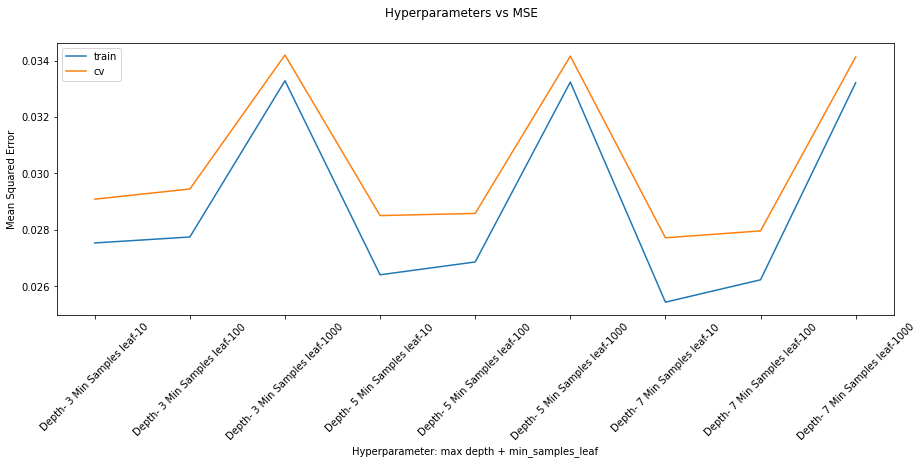

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.422947
idiot,0.248188
crap,0.079823
moron,0.063167
damn,0.062279
ignor,0.057615
dumb,0.050544
work,0.002746
see,0.002105
thing,0.001806


### 3. Features for LSTM:

In [ ]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [ ]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [ ]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [ ]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(28831, 350)
(9611, 350)
(57803, 350)


In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          2544300   
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,794,285
Trainable params: 2,794,285
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train,epochs=5,batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5


In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)